
# <p style="text-align: center;">EE 380L: Data Mining</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 80</p>
## <p style="text-align: center;">Due: Tuesday, March 20th, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1 - Gradient Descent (5+12+3 = 20pts)

In this question you will implement vanilla SGD and 2 adaptive gradient update techniques called Adagrad and Adadelta. In addition, you will also implement ridge regularization. 

1. Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, submit that as a separate file and make a reference to it in your notebook or include the image in your notebook.
2. Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $$ Try to format similarly to scikit-learn's models. Your Python class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'SGD', 'adagrad' or 'adadelta' (Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 20 epochs (this may have to increase for adadelta), using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch count (20 epochs) for the best combination of learning_rate and regularization for both SGD, Adagrad and Adadelta. ie you should have a plot of MSE and parameter updates for SGD, adagrad and adadelta. Report the MSE at the end of 10 epochs for all 3.
3. Based on the experiments, answer the following:

1. Among SGD and Adagrad, which one allows for larger initial setting of the learning_rate? Why?
2. Mention one benefit and one drawback of Adadelta over Adagrad

# Notes on Adagrad/Adadelta
Adagrad (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. A cache is maintained that holds the sum of squares of all gradients upto the current update. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = cache + (gradients^2)
2. weights = weights + ((learning_rate)/sqrt(cache+1e-6))*gradients

The key difference between Adadelta and Adagrad is that the former uses a weighted sum for each update of the cache. Also, you will not need to use a learning rate to make Adadelta work. In addition to the link above, the paper on Adadelta is a great resource to implement it correctly (https://arxiv.org/pdf/1212.5701.pdf)

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

### 1
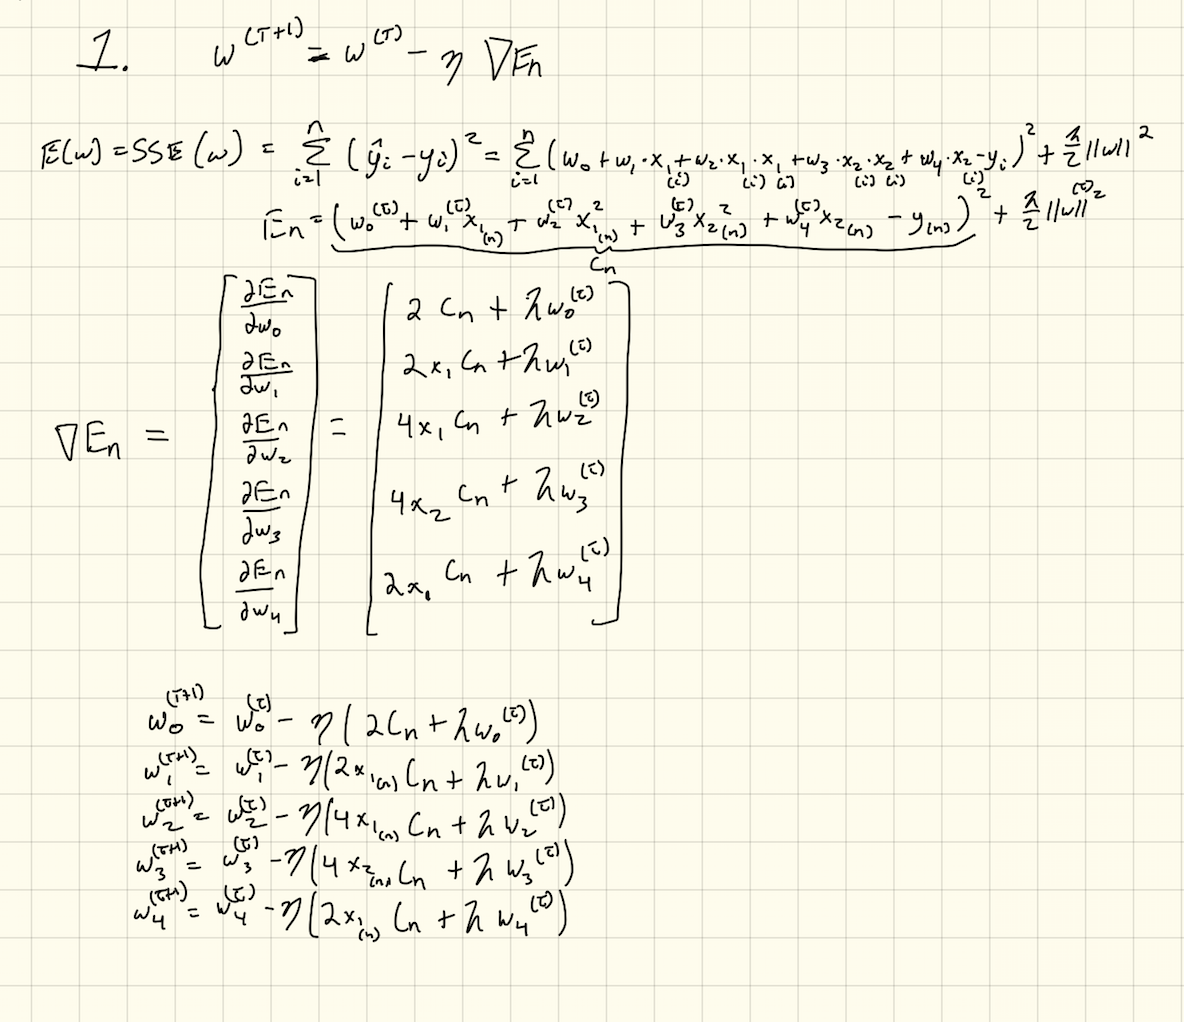

### 2

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class SGD:
    def __init__(self, learning_rate, regularization_constant, epochs):
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        self.epochs = epochs
        self.plot_weights = []
        self.plot_errors = []
        self.plot_epoch = []
        self.epoch_num = 0
        self.weights = np.random.random_sample(5,)
        self.X = []
        self.y = []
        self.update_mode = 0
        
        
        
    def fit(self, X, y, update_rule="SGD"):
        if(update_rule == 'adagrad'):
            self.update_mode = 1
        elif(update_rule == 'adadelta'):
            self.update_mode = 2
        self.X = X
        self.y = y
        self.evaluate_model()
        self.epoch_num = self.epoch_num + 1
        while (self.epoch_num <= self.epochs):
            for index in range(len(X)):
                truth = y[index]
                features = X[index]
                print("This is truth: ", truth)
                print("This is features: ", features)
                prediction = self.predict_one(features)
                print("This is prediction: ", prediction)
                error = self.compute_error(truth,prediction)
                gradients = self.compute_gradients(error, features)
                self.update_weights(gradients)
            self.evaluate_model()
            self.epoch_num = self.epoch_num + 1
        
    def evaluate_model(self):
        predictions = self.predict_all(X)
        mse = mean_squared_error(y,predictions)
        self.plot_errors.append(mse)
        self.plot_weights.append(self.weights) #may want to do deep copy here
        self.plot_epoch.append(self.epoch_num)
        print("MSE: ", mse, " Epoch_num: ", self.epoch_num)
    def predict_all(self, X):
        predictions = []
        for x in X:
            predictions.append(self.predict_one(x))
        return predictions
            
    def predict_one(self, X):
        return self.weights[0] + X[0]*self.weights[1] + X[0]*X[0]*self.weights[2] \
            + X[1]*X[1]*self.weights[3] + X[1]*self.weights[4] 
        
    def compute_error(self, truth, prediction):
        return prediction - truth
    
    def compute_gradients(self, error, features):
        gradients = []
        gradients.append(2*error + self.regularization_constant*self.weights[0])
        gradients.append(2*features[0]*error + self.regularization_constant*self.weights[1])
        gradients.append(2*features[0]*features[0]*error + self.regularization_constant*self.weights[2])
        gradients.append(2*features[1]*features[1]*error + self.regularization_constant*self.weights[3])
        gradients.append(2*features[1]*error + self.regularization_constant*self.weights[4])
        print("These are gradients: ", gradients)
        return gradients
    
    def update_weights(self, gradients):
        print("Beginning weights: ", self.weights)
        if(self.update_mode == 0):
            self.weights[0] = self.weights[0] - self.learning_rate*gradients[0] 
            self.weights[1] = self.weights[1] - self.learning_rate*gradients[1]
            self.weights[2] = self.weights[2] - self.learning_rate*gradients[2]
            self.weights[3] = self.weights[3] - self.learning_rate*gradients[3]
            self.weights[4] = self.weights[4] - self.learning_rate*gradients[4]
        print("Ending weights: ", self.weights)
    
    
print ("Hello")
df = pd.read_csv('samples.csv')
df = df.dropna()
X = df[[u'x_1',u'x_2']]
X = X.as_matrix()
X = X.astype('float')
y = df[[u'y']]
y = y.as_matrix()
y = np.array(y)
y = y.astype('float')
sgd = SGD(0.001,0,1)
sgd.fit(X,y)

Hello
MSE:  13.261573851787162  Epoch_num:  0
This is truth:  [-2.722]
This is features:  [0.615 0.666]
This is prediction:  1.3730278531138675
These are gradients:  [array([8.19005571]), array([5.03688426]), array([3.09768382]), array([3.63274835]), array([5.4545771])]
Beginning weights:  [0.26520751 0.5161628  0.64051373 0.58650812 0.43239147]
Ending weights:  [0.25701746 0.51112592 0.63741604 0.58287537 0.42693689]
This is truth:  [-2.286]
This is features:  [0.681 0.562]
This is prediction:  1.3247391296796112
These are gradients:  [array([7.22147826]), array([4.91782669]), array([3.34903998]), array([2.28086058]), array([4.05847078])]
Beginning weights:  [0.25701746 0.51112592 0.63741604 0.58287537 0.42693689]
Ending weights:  [0.24979598 0.50620809 0.634067   0.58059451 0.42287842]
This is truth:  [-3.75]
This is features:  [0.025 0.389]
This is prediction:  0.5152033185214111
These are gradients:  [array([8.53040664]), array([0.21326017]), array([0.0053315]), array([1.29082966])

Beginning weights:  [-0.44253139  0.22933808  0.47196846  0.29753886  0.02451812]
Ending weights:  [-0.44872585  0.22632757  0.47050535  0.29493778  0.02050411]
This is truth:  [-3.787]
This is features:  [0.33  0.847]
This is prediction:  -0.09384172321852352
These are gradients:  [array([7.38631655]), array([2.43748446]), array([0.80436987]), array([5.29900997]), array([6.25621012])]
Beginning weights:  [-0.44872585  0.22632757  0.47050535  0.29493778  0.02050411]
Ending weights:  [-0.45611216  0.22389009  0.46970098  0.28963877  0.0142479 ]
This is truth:  [-0.14]
This is features:  [0.898 0.209]
This is prediction:  0.13933940289258437
These are gradients:  [array([0.55867881]), array([0.50169357]), array([0.45052082]), array([0.02440365]), array([0.11676387])]
Beginning weights:  [-0.45611216  0.22389009  0.46970098  0.28963877  0.0142479 ]
Ending weights:  [-0.45667084  0.22338839  0.46925046  0.28961436  0.01413113]
This is truth:  [-2.489]
This is features:  [0.695 0.807]
This 

This is truth:  [-2.977]
This is features:  [0.204 0.272]
This is prediction:  -0.9770310951994037
These are gradients:  [array([3.99993781]), array([0.81598731]), array([0.16646141]), array([0.2959314]), array([1.08798308])]
Beginning weights:  [-0.93710037  0.05094074  0.37918349  0.09435635 -0.2686897 ]
Ending weights:  [-0.94110031  0.05012476  0.37901703  0.09406042 -0.26977768]
This is truth:  [-1.836]
This is features:  [0.756 0.505]
This is prediction:  -0.7988340861435004
These are gradients:  [array([2.07433183]), array([1.56819486]), array([1.18555532]), array([0.52900647]), array([1.04753757])]
Beginning weights:  [-0.94110031  0.05012476  0.37901703  0.09406042 -0.26977768]
Ending weights:  [-0.94317464  0.04855656  0.37783147  0.09353141 -0.27082522]
This is truth:  [-1.387]
This is features:  [0.918 0.713]
This is prediction:  -0.7257419759657011
These are gradients:  [array([1.32251605]), array([1.21406973]), array([1.11451601]), array([0.67232616]), array([0.94295394])

Beginning weights:  [-1.2085654  -0.02644218  0.35101721 -0.02986366 -0.4435949 ]
Ending weights:  [-1.212924   -0.02793718  0.35050442 -0.0319148  -0.4465849 ]
This is truth:  [-3.893]
This is features:  [0.207 0.59 ]
This is prediction:  -1.4782828730478053
These are gradients:  [array([4.82943425]), array([0.99969289]), array([0.20693643]), array([1.68112606]), array([2.84936621])]
Beginning weights:  [-1.212924   -0.02793718  0.35050442 -0.0319148  -0.4465849 ]
Ending weights:  [-1.21775344 -0.02893688  0.35029748 -0.03359593 -0.44943427]
This is truth:  [-1.106]
This is features:  [0.969 0.964]
This is prediction:  -1.3813527938229822
These are gradients:  [array([-0.55070559]), array([-0.53363371]), array([-0.51709107]), array([-0.5117685]), array([-0.53088019])]
Beginning weights:  [-1.21775344 -0.02893688  0.35029748 -0.03359593 -0.44943427]
Ending weights:  [-1.21720273 -0.02840324  0.35081457 -0.03308416 -0.44890339]
This is truth:  [-3.635]
This is features:  [0.382 0.808]
T

These are gradients:  [array([-0.33894385]), array([-0.27895079]), array([-0.2295765]), array([-0.05559527]), array([-0.13727226])]
Beginning weights:  [-1.3723493  -0.05553392  0.35164557 -0.10930516 -0.5547387 ]
Ending weights:  [-1.37201036 -0.05525497  0.35187515 -0.10924956 -0.55460142]
This is truth:  [-3.774]
This is features:  [0.299 0.999]
This is prediction:  -2.0201515964009658
These are gradients:  [array([3.50769681]), array([1.04880135]), array([0.3135916]), array([3.50068492]), array([3.50418911])]
Beginning weights:  [-1.37201036 -0.05525497  0.35187515 -0.10924956 -0.55460142]
Ending weights:  [-1.37551805 -0.05630377  0.35156155 -0.11275025 -0.55810561]
This is truth:  [-3.336]
This is features:  [0.074 0.295]
This is prediction:  -1.552212627016499
These are gradients:  [array([3.56757475]), array([0.26400053]), array([0.01953604]), array([0.31046819]), array([1.05243455])]
Beginning weights:  [-1.37551805 -0.05630377  0.35156155 -0.11275025 -0.55810561]
Ending weigh

Beginning weights:  [-1.51589687 -0.06612875  0.36330766 -0.18802548 -0.66256682]
Ending weights:  [-1.52031894 -0.06631448  0.36329986 -0.19126569 -0.66635212]
This is truth:  [-2.584]
This is features:  [0.576 0.504]
This is prediction:  -1.8224079170599472
These are gradients:  [array([1.52318417]), array([0.87735408]), array([0.50535595]), array([0.38691315]), array([0.76768482])]
Beginning weights:  [-1.52031894 -0.06631448  0.36329986 -0.19126569 -0.66635212]
Ending weights:  [-1.52184212 -0.06719183  0.36279451 -0.1916526  -0.6671198 ]
This is truth:  [0.611]
This is features:  [0.872 0.037]
This is prediction:  -1.3295160700850523
These are gradients:  [array([-3.88103214]), array([-3.38426003]), array([-2.95107474]), array([-0.00531313]), array([-0.14359819])]
Beginning weights:  [-1.52184212 -0.06719183  0.36279451 -0.1916526  -0.6671198 ]
Ending weights:  [-1.51796109 -0.06380757  0.36574558 -0.19164729 -0.6669762 ]
This is truth:  [0.88]
This is features:  [0.943 0.053]
Thi

This is features:  [0.616 0.037]
This is prediction:  -1.4736866572314593
These are gradients:  [array([-1.87537331]), array([-1.15522996]), array([-0.71162166]), array([-0.00256739]), array([-0.06938881])]
Beginning weights:  [-1.57362399 -0.04187472  0.40277576 -0.23356129 -0.72388576]
Ending weights:  [-1.57174862 -0.04071949  0.40348739 -0.23355872 -0.72381637]
This is truth:  [-3.989]
This is features:  [0.254 0.815]
This is prediction:  -2.3011058594353577
These are gradients:  [array([3.37578828]), array([0.85745022]), array([0.21779236]), array([2.24228297]), array([2.75126745])]
Beginning weights:  [-1.57174862 -0.04071949  0.40348739 -0.23355872 -0.72381637]
Ending weights:  [-1.57512441 -0.04157694  0.40326959 -0.235801   -0.72656764]
This is truth:  [-0.567]
This is features:  [0.862 0.267]
This is prediction:  -1.5221202538435037
These are gradients:  [array([-1.91024051]), array([-1.64662732]), array([-1.41939275]), array([-0.13617914]), array([-0.51003422])]
Beginning we

Beginning weights:  [-1.62484979 -0.0210288   0.43337392 -0.26322342 -0.76658233]
Ending weights:  [-1.62673054 -0.02159867  0.43320125 -0.26337193 -0.76711082]
This is truth:  [-3.662]
This is features:  [0.321 0.627]
This is prediction:  -2.173543843611757
These are gradients:  [array([2.97691231]), array([0.95558885]), array([0.30674402]), array([1.17031056]), array([1.86652402])]
Beginning weights:  [-1.62673054 -0.02159867  0.43320125 -0.26337193 -0.76711082]
Ending weights:  [-1.62970745 -0.02255426  0.43289451 -0.26454224 -0.76897734]
This is truth:  [-2.259]
This is features:  [0.747 0.87 ]
This is prediction:  -2.274238753398956
These are gradients:  [array([-0.03047751]), array([-0.0227667]), array([-0.01700672]), array([-0.02306842]), array([-0.02651543])]
Beginning weights:  [-1.62970745 -0.02255426  0.43289451 -0.26454224 -0.76897734]
Ending weights:  [-1.62967697 -0.02253149  0.43291151 -0.26451917 -0.76895082]
This is truth:  [-3.932]
This is features:  [0.272 0.772]
Thi

Beginning weights:  [-1.68335578  0.01461806  0.48219421 -0.30228867 -0.81918876]
Ending weights:  [-1.68475826  0.01391822  0.48184499 -0.30342217 -0.8204496 ]
This is truth:  [-2.548]
This is features:  [0.665 0.974]
This is prediction:  -2.549385991353436
These are gradients:  [array([-0.00277198]), array([-0.00184337]), array([-0.00122584]), array([-0.00262971]), array([-0.00269991])]
Beginning weights:  [-1.68475826  0.01391822  0.48184499 -0.30342217 -0.8204496 ]
Ending weights:  [-1.68475549  0.01392006  0.48184621 -0.30341954 -0.8204469 ]
This is truth:  [-1.341]
This is features:  [0.539 0.132]
This is prediction:  -1.6508519088996103
These are gradients:  [array([-0.61970382]), array([-0.33402036]), array([-0.18003697]), array([-0.01079772]), array([-0.0818009])]
Beginning weights:  [-1.68475549  0.01392006  0.48184621 -0.30341954 -0.8204469 ]
Ending weights:  [-1.68413579  0.01425408  0.48202625 -0.30340874 -0.8203651 ]
This is truth:  [-2.584]
This is features:  [0.603 0.55

# Question 2. (6+4=10 pts) Tensor Playground
Visit http://playground.tensorflow.org for this problem

A. From the far right, select "Regression" as the problem type, and select the 2nd of the two data sets ( the right one ).  

   i) What sort of test / training loss do you get if you run it for 200 epochs with the following learning rates: .3, .01 and .003 ?  What if you run it for 1000 epochs with these learning rates?  Leave all other values at their defaults ( test/training ratio 50%, Noise 0, Batch Size 10, using Tanh activation function, and No Regularization )
   
   ii) Keeping learning rate at .3, Activation at Tanh, with all others at their defaults, and running for 200 epochs.  
     What sort of test/train loss can you achieve using only 1 neuron in the first hidden layer.  What about for 2,3 or 8 neurons?  Provide screen shots of output layer and comment on how the different output fits look and compare with one another.

   iii)Now keeping learning rate at .03 with all others at their defaults, and running for 200 epochs.  
       Compare how the activation functions affect the ouput ( ReLU, Sigmoid, Tanh, Linear ). Provide screen shots of output results and comment.


B. Neural Nets can fit anything.  Now reset to the initial defaults, and select "Classification" as the problem type, and from the Data section, select the bottom right "Spriral" data set.  With the idea of trying to minimize training/testing error, provide solutions to the problem for the following 2 scenarios.  i) Using just the first 2 inputs ( as per default ) and ii) Using all 7 of the inputs.  You may use as many layers as you want, whatever activation, however man neurons.  Provide screen shots which show your full network, output and parameters. Briefly justify your decisions, and comment on difficulties/tradeoffs, what helps/what doesn't,etc. 

## ANSWER

### i
200 Epochs
0.3 - test loss: 0.020, training loss: 0.016

0.01 - test loss: .04, training loss: 0.03

0.003 - test loss: 0.046, training loss: 0.036

1000 Epochs
0.3 - test loss: 0.012, training loss: 0.009

0.01 - test loss: 0.019, training loss: 0.016

0.003 - test loss: 0.024, training loss: 0.019

### ii
1 Neuron in Hidden Layer
test: 0.041, training: 0.038
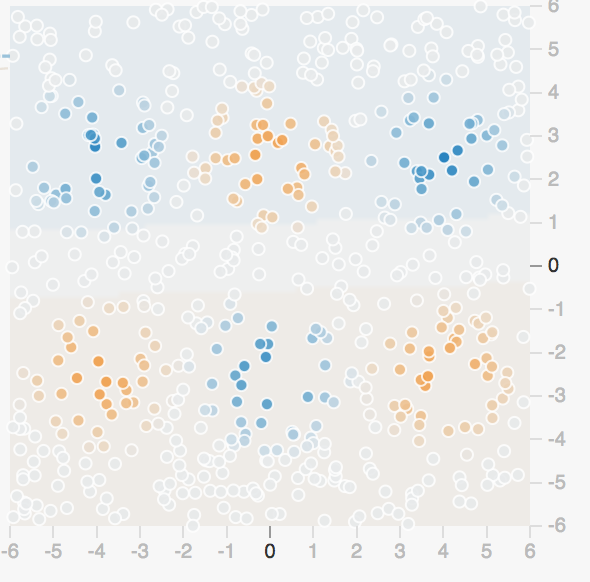


2 Neurons in Hidden Layer
test: 0.029, training: 0.027
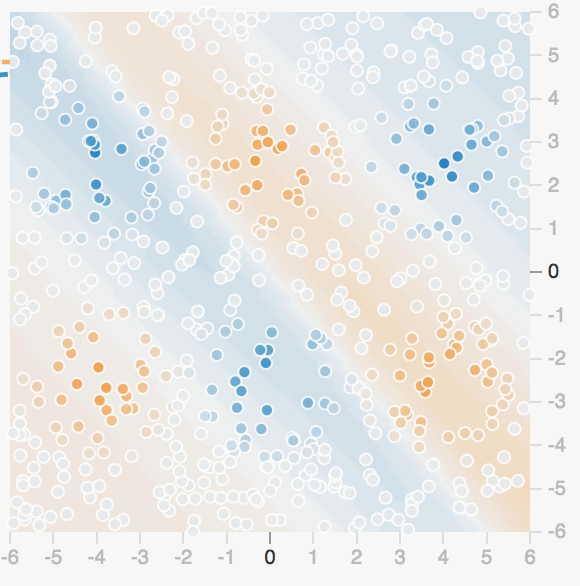

3 neurons in Hidden Layer
test: 0.022, training: 0.020
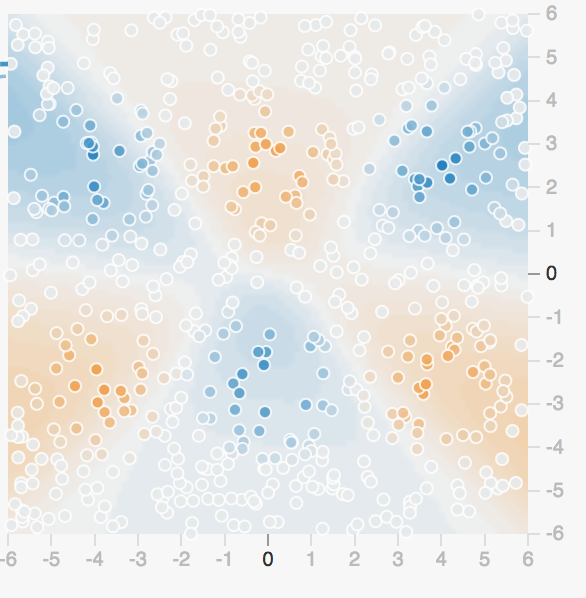

8 neurons in Hidden Layer
test: 0.016, training: 0.015
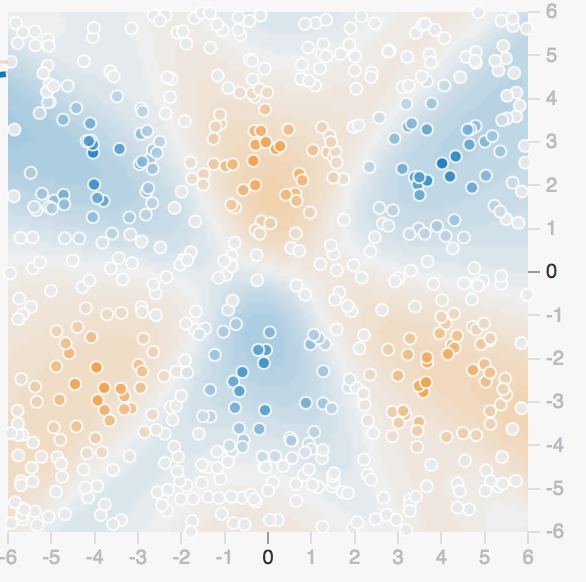

### iii

tanh, test loss: 0.022, training loss 0.020
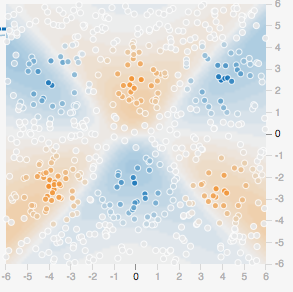

RelU, test loss: 0.027, training loss 0.027
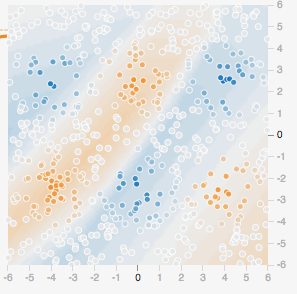

Sigmoid, test loss: 0.041, training loss 0.044
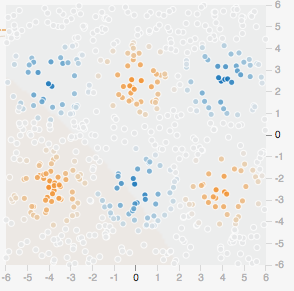

Linear, test loss: 0.040, training loss 0.044
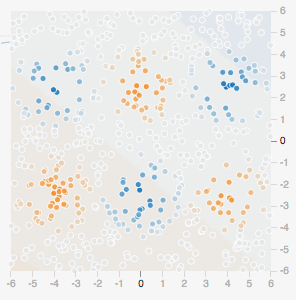

### b part i
relu
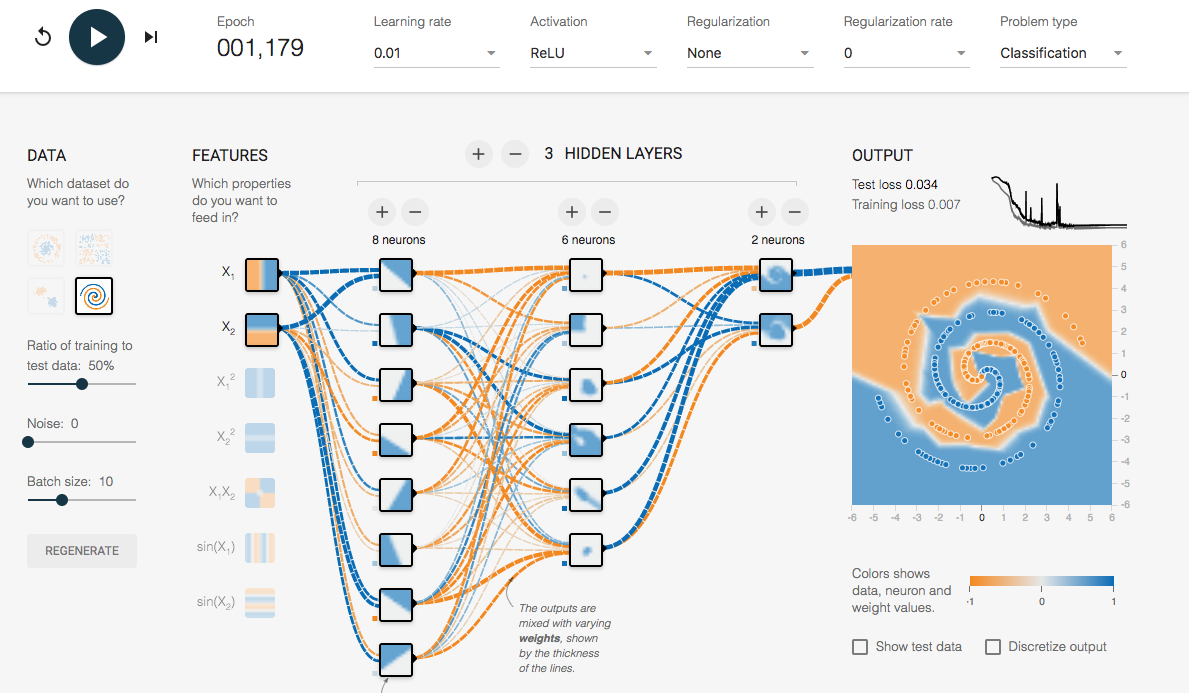

### ii
tanh
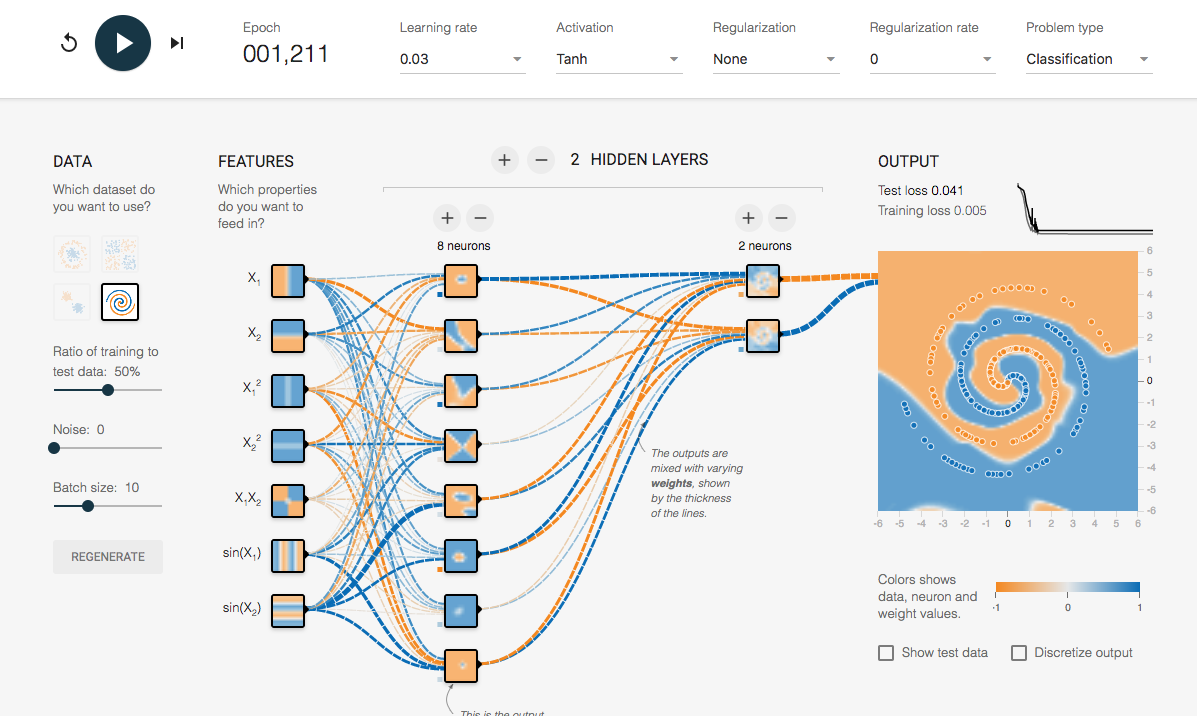

# Question 3: Multi-layer Perceptron Regressor (15 points)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the OpenCL gemm kernel performance prediction dataset for this problem https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 42** and **test_size = 0.33**.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((161872, 14), (161872,), (79728, 14), (79728,))


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. 

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, learning_rate_init = 0.005
    
Now, consider the following settings for the number of hidden units:
    
        (2,), (10,), (20,), (30,), (40,)
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model (5pts)
      
2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Activation Layer: Use the tanh and relu activations for the following fixed parameters to train your model:
    
    solver = 'sgd', random_state=42,
    batch_size=5000, hidden_layer_sizes = (2,)

   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model. (2pts)
   
5) Optimization technique: The sklearn API performs a momentum update when using SGD. To understand the difference in performance of vanilla SGD and SGD with momentum, set momentum to 0 with SGD. Here, we compare the performance of vanilla sgd against adam solvers. Since both of these use different optimization subroutines, the learning rate must also be varied. In this question, vary the learning rate through these values [1, 0.1, 0.01, 0.001]. Keep the following fixed parameters to train your model:

    activation = 'tanh', random_state=42,
    batch_size=5000, hidden_layer_sizes = (2,), momentum = 0
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for the best learning rate for each model. (3pts)

## Solution

### 1)

# Question 4: Multi-level Model in Python (20 points)
In this problem, you will explore multi-level model using a python package [PyMC3](https://pymc-devs.github.io/pymc3/index.html#). The dataset "brew_by_year.csv" will be used in this question.  This dataset contains fields:

- `state`
- `state_id`
- `brew`
- `year`

Where 'brew' is the number of breweries in the state that year, and `state_id` is a unique ID for that state.

(a)  (2 pts) Plot the relationship between number of breweries and year, and draw a linearly regressed line ignoring the ID variable.

(b)  (2 pts) Plot the relationship between number of breweries and year, but this time, fit a different linear regression for each state.

(c)  (2 + 4 + 6 pts) Divide the dataset into training and test sets.  The training set contains the first 6 years of the measurements, and the test set contains the rest of the measurements. 
Build three different linear models:
- Global model:  a linear model using `brew` as the dependent variable and `year` as the independent variable. Pool all data and estimate one common regression model to assess the influence of the passage of time across the total number of breweries.
- Local model:  a different linear model for each state i.e., 51 different linear regressions. We are interested in whether different states actually follow separate regression models.
- Multilevel model:  Use the [PyMC3](http://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html#Partial-pooling:-Hierarchical-Regression-aka,-the-best-of-both-worlds) package to fit a multilevel model specified as follows:

\begin{align*}
\text{brew}_{it} &= \beta_{0i} + \beta_{1i} \text{year}_{it} + \epsilon_{it}\\
\beta_{0i} &= \beta_{00}  + \eta_{0i} \\
\beta_{1i} &= \beta_{10} + \eta_{1i} \\
\end{align*}

Predict the number of breweries for the next 2 years, and calculate the mean squared errors from the three models.

(d)  (2 pts) Briefly state what do $\beta_{00}$ and $\beta_{10}$ mean in this multilevel model.

(e) (2 pt) Visually assess from the trace plot whether the MLM specified in the problem is a reasonable choice.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

data = pd.read_csv('brew_by_year.csv', index_col=0)
data['brew'] = (data['brew'] - np.mean(data['brew'])) / np.std(data['brew'])

# Specify the hyper-parameter of Multilevel model:
beta_00 = pm.Normal('mu_beta0', mu=0., sd=10)
eta_0i = pm.HalfCauchy('eta_0', 5)
beta_10 = pm.Normal('mu_beta1', mu=0., sd=10)
eta_1i = pm.HalfCauchy('eta1', 5)
    
# Intercept and Slope
beta_0i = pm.Normal('beta0', mu=beta_00, sd=eta_0i, shape=len(train_data.state_id.unique()))
beta_1i = pm.Normal('beta1', mu=beta_10, sd=eta_1i, shape=len(train_data.state_id.unique()))    
# Model error
eps = pm.HalfCauchy('eps', 5)

## Answer

# Question 5: Decision Tree using Python (5 pts)
In this problem, you will model the data using decision trees to perform a classification task on the energy dataset provided. The dataset has been preprocessed. Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree), build two different trees with a maximum depth of two using the split criteria (i) Gini and (ii) Entropy. Use entire data to build trees. Plot the two trees. If your classifier object is called clf, use the following commands to save the generated tree as a '.dot' file that can be used to visualize the tree using Webgraphviz: http://www.webgraphviz.com/

Hint: see  http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

Copy paste the contents of your '.dot' file into the text window on the website to visualize the trees. At which node(s) do they differ?

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('energydata_complete.csv') 

y = data['Appliances']
X = data.drop(['date','Appliances', 'rv1', 'rv2'], axis = 1)


from dateutil import parser
timeData = np.array(data['date'])

days = []
hours = []
for line in xrange(len(timeData)):
    day = parser.parse(timeData[line]).weekday()
    hour = parser.parse(timeData[line]).hour
    days.append(day)
    hours.append(hour)
    
X = pd.concat([X, pd.get_dummies(days), pd.get_dummies(hours)], axis = 1)

# Question 6. (2+5+3=10 pts) Bayes Decision Theory
a. Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.
( 2 points )

b. Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the customer does not buy a TV and 1 if they do. For each customer, you are given two features, $x_1$ is the per hour salary and $x_2$ is the age. Assume that the class conditional distribution $p([x_1 , x_2]|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 15 and 40 respectively and that of those who don’t is 8.5 and 25. The first class of customers, $\sigma_1$ = 1, $\sigma_2 = 2$ and $\rho = 0$. For the second class of customers, $\sigma_1$ = 3, $\sigma_2 = 2$ and $\rho = 0$.(Refer HW1 on how to construct a covariance matrix with this information). Further, your sales data suggests that only 1 in 3 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem. (5 points)

c. Now sample 1000 customers from each class (C = 0, 1) under the assumed distribution and the estimated parameters and plot their features. Additionally, plot the decision boundary you obtained in the part (b) on the same plot. (3 points)

## ANSWER